In [90]:
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
# Use the pandas read_csv method to read the file
df = pd.read_csv('data01.csv')
df

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,171130,0.0,62,1,25.516870,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,101659,0.0,78,1,25.822710,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,162069,0.0,85,2,23.891779,1,1,0,1,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,120967,0.0,79,2,35.288554,0,0,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


## Initial Feature Removal

In [3]:
def drop_initial_features(df):
    """
    Author: Novin
    Drop the initial features based on the trend and the information value
    
    Parameters:
        - df: pandas dataFrame with all of the input features 
        
    Returns:
        - df_updated: pandas dataframe with initial features dropped and outcome converted to an int
    """
    
    # define the feature to drop 
    feature_drop_list = ['group','ID','diabetes','deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD'] 
    df_updated = df.drop(feature_drop_list, axis=1)

    # Drop the row where outcome = NULL
    # df_updated = df_updated.dropna(subset=['outcome'])

    # Convert outcome into 1 and 0 values
    df_updated['outcome'] = df_updated['outcome'].apply(lambda x: 0 if x < 0.5 else 1)
    
    return df_updated

In [4]:
df_updated = drop_initial_features(df)

## Missing Imputation

In [5]:
def missing_imputation(df):
    """
    Author: Novin
    Fills missing values with either median or mean based on the skewness of the columns.
    
    Parameters:
        - df: initial features removed 
        
    Returns:
        - filled_df: missing values in continous columns are replaces with mean or median
    """
    # Calculate skewness of each column
    skewness = df.skew()

    # Create a copy of the input DataFrame to avoid modifying the original DataFrame
    filled_df = df.copy()
    
    output_col = 'outcome'

    # Group the data by the output column
    groups = filled_df.groupby(output_col)

    # Fill missing values with mean/median based on the output column value
    for col in df.columns:
        if col != output_col:
            
            # If the skewness is greater than 0.5, not a normal distribution
            # therefore, replace with median else replace with mean
            if skewness[col] > 0.5:
                filled_df[col] = groups[col].apply(lambda x: x.fillna(x.median()))
            else:
                filled_df[col] = groups[col].apply(lambda x: x.fillna(x.mean()))

    return filled_df

In [6]:
filled_df = missing_imputation(df_updated)
df_updated = filled_df

C:\Users\Bertram\AppData\Local\Temp\ipykernel_23200\685745837.py:32: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  filled_df[col] = groups[col].apply(lambda x: x.fillna(x.mean()))
C:\Users\Bertram\AppData\Local\Temp\ipykernel_23200\685745837.py:32: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  f

## Feature Engineering

### Frank's Part

In [7]:
Good_range = {"M": dict(), "F": dict()}
information = dict()

# Initialize the good range values for male patients
Good_range['M']['age'] = (30, 35)
Good_range['M']['BMI'] = (18.5, 24.9)
Good_range['M']["Systolic blood pressure"] = (90.0, 120.0)
Good_range['M']['Diastolic blood pressure'] = (60, 80)
Good_range['M']["Respiratory rate"] = (12.0, 20.0)
Good_range['M']["temperature"] = (36.5, 37.5)
Good_range['M']["SP O2"] = (95.0, 100.0)
Good_range['M']["Urine output"] = (500.0, 2000.0)
Good_range['M']["Hematocrit"] = (38.8, 50)
Good_range['M']["Heart rate"] = (60.0, 100.0)
Good_range['M']["Diastolic blood pressure"] = (60.0, 80.0)
Good_range['M']["RBC"] = (4.7, 6.1)
Good_range['M']["MCH"] = (27.0, 33.0)
Good_range['M']["MCHC"] = (33, 36.0)
Good_range['M']["MCV"] = (80.0, 100.0)
Good_range['M']["RDW"] = (11.5, 14.5)
Good_range['M']["Leucocyte"] = (4, 11)
Good_range['M']["Platelets"] = (150, 450)
Good_range['M']["Neutrophils"] = (18.0, 75.0)
Good_range['M']["Basophils"] = (0.0, 0.2)
Good_range['M']["Lymphocytes"] = (10.0, 48.0)
Good_range['M']["PT"] = (11.0, 13.5)
Good_range['M']["INR"] = (0.8, 1.2)
Good_range['M']["Creatine kinase"] = (39, 308)
Good_range['M']["Creatinine"] = (0.74, 1.35)
Good_range['M']["Urea nitrogen"] = (6.0, 20.0)
Good_range['M']["Glucose"] = (70, 100)
Good_range['M']["Blood potassium"] = (3.6, 5.2)
Good_range['M']["Blood sodium"] = (135.0, 145.0)
Good_range['M']["Blood calcium"] = (8.6, 10.3)
Good_range['M']["Chloride"] = (96.0, 106.0)
Good_range['M']["Anion gap"] = (3.0, 11.0)
Good_range['M']["Magnesium ion"] = (1.7, 2.2)
Good_range['M']["pH"] = (7.35, 7.45)
Good_range['M']["Bicarbonate"] = (22.0, 29.0)
Good_range['M']["Lactic acid"] = (0.45, 1.98)
Good_range['M']["PCO2"] = (35.0, 45.0)
Good_range['M']["EF"] = (50, 70)

# Initialize the good range values for female patients
Good_range['F']['BMI'] = (18.5, 24.9)
Good_range['F']['age'] = (23, 30)
Good_range['F']["Systolic blood pressure"] = (90.0, 120.0)
Good_range['F']['Diastolic blood pressure'] = (60, 80)
Good_range['F']["Respiratory rate"] = (12.0, 20.0)
Good_range['F']["temperature"] = (36.5, 37.5)
Good_range['F']["SP O2"] = (95.0, 100.0)
Good_range['F']["Urine output"] = (500.0, 2000.0)
Good_range['F']["Hematocrit"] = (34.9, 44.5)
Good_range['F']["Heart rate"] = (60.0, 100.0)
Good_range['F']["Diastolic blood pressure"] = (60.0, 80.0)
Good_range['F']["RBC"] = (4.2, 5.4)
Good_range['F']["MCH"] = (27.0, 33.0)
Good_range['F']["MCHC"] = (33, 36.0)
Good_range['F']["MCV"] = (80.0, 100.0)
Good_range['F']["RDW"] = (11.5, 14.5)
Good_range['F']["Leucocyte"] = (4, 11)
Good_range['F']["Platelets"] = (150, 450)
Good_range['F']["Neutrophils"] = (18.0, 75.0)
Good_range['F']["Basophils"] = (0, 0.2)
Good_range['F']["Lymphocytes"] = (10.0, 48.0)
Good_range['F']["PT"] = (11.0, 13.5)
Good_range['F']["INR"] = (0.8, 1.2)
Good_range['F']["Creatine kinase"] = (26, 192)
Good_range['F']["Creatinine"] = (0.59, 1.04)
Good_range['F']["Urea nitrogen"] = (6.0, 20.0)
Good_range['F']["Glucose"] = (70, 100)
Good_range['F']["Blood potassium"] = (3.6, 5.2)
Good_range['F']["Blood sodium"] = (135.0, 145.0)
Good_range['F']["Blood calcium"] = (8.6, 10.3)
Good_range['F']["Chloride"] = (96.0, 106.0)
Good_range['F']["Anion gap"] = (3.0, 11.0)
Good_range['F']["Magnesium ion"] = (1.7, 2.2)
Good_range['F']["pH"] = (7.35, 7.45)
Good_range['F']["Bicarbonate"] = (22.0, 29.0)
Good_range['F']["Lactic acid"] = (0.45, 1.98)
Good_range['F']["PCO2"] = (35.0, 45.0)
Good_range['F']["EF"] = (50, 70)

#count howmany unserious_diseases the patient has
def unserious_count(df, not_serious_list):
    unserious = []
    for i in range(len(df)):
        row = df.iloc[i]
        counter = 0
        for col in df.columns:
            if col in not_serious_list:
                counter = counter + df.iloc[i][col]
        unserious.append(counter)
    return unserious

# Define a function to transform values based on given parameters
def more_extrem(x, lower,  upper, upper_index, lower_index):
    average = (lower + upper) / 2
    if x >= lower and upper >= x:
        if x < average:
            return average + (average - x) 
        return x
    elif x > upper:
        return upper + upper_index * (x - upper)
    else:
        return (lower - x) * lower_index + upper
    
# Define a function to count the number of features outside the good range
def num_outside_range(patient_data, gender, Good_range):
    num_outside = 0
    for i in range(patient_data.shape[0]):
        feature = df.columns[i]
        if feature == 'gendera' or feature == 'age':
            continue
        val = patient_data[i]
        if gender == 'M':
            lower, upper = Good_range['M'][feature]
        else:
            lower, upper = Good_range['F'][feature]
        if val < lower or val > upper:
            num_outside += 1
    return num_outside

# Define a function to process the age column based on gender
def age_processing(df, upper_index, lower_index):
    for index, row in df.iterrows():
        gender = row['gendera']
        if gender == 1:
            # if gender is M
            df.at[index, 'age'] = more_extrem(row['age'], Good_range['M']['age'][0], Good_range['M']['age'][1], upper_index, lower_index)
        else:
            # if gender is F
            df.at[index, 'age'] = more_extrem(row['age'], Good_range['F']['age'][0], Good_range['F']['age'][1], upper_index, lower_index)

# Define a function to generate a list of health indicators
def count_unhealthy_indicator(df, Good_range):
    howmany = []
    for i in range(len(df)):
        row = df.iloc[i]
        gender = 'M' if row['gendera'] == 1 else 'F'
        num_outside_range = 0
        for col in df.columns:
            if col in Good_range[gender]:
                lower, upper = Good_range[gender][col]
                if row[col] < lower or row[col] > upper:
                    num_outside_range += 1
        howmany.append(num_outside_range)
    return howmany

# Define a function to check if a column has binary values
def is_binary(column):
    return set(column.unique()).issubset({0, 1})

# Define a function to generate a correlation list
def correlatioin_list_generate(df):
    for i in range(len(df)):
        row = df.iloc[i]
        gender = 'M' if row['gendera'] == 1 else 'F'
        num_outside_range = 0
        for col in df.columns:
            if col in Good_range[gender]:
                df.at[i, col] = more_extrem(df.at[i, col], Good_range[gender][col][0], Good_range[gender][col][1], 1.9, 14.9)

    correlation = {col: {'corr': None, 'r2': None} for col in df.columns}
    y = Y
    for col in df.columns:
        X_col = df[[col]]
        print(X_col)
        model = LinearRegression()
        model.fit(X_col, y)
        corr = np.corrcoef(X_col.T, y)[0, 1]
        r2 = model.score(X_col, y)
        correlation[col]['corr'] = corr
        correlation[col]['r2'] = r2
    return correlation

In [8]:
# Process the age column
age_processing(df_updated, 4.1, 7)

In [9]:
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Systolic blood pressure,Diastolic blood pressure,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0,186.7,1,37.588179,0,0,0,68.837838,155.866667,68.333333,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.5,40.000000,55
1,0,214.5,2,28.479451,0,0,0,101.370370,140.000000,65.000000,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225000,33.444444,0.5,78.000000,55
2,0,247.3,2,26.572634,0,0,0,72.318182,135.333333,61.375000,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.5,71.500000,35
3,0,83.3,2,83.264629,0,0,0,94.500000,126.400000,73.200000,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.6,75.000000,55
4,0,214.5,2,31.824842,1,0,0,67.920000,156.560000,58.120000,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250000,22.000000,0.6,50.000000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,145.7,1,25.516870,1,1,0,100.125000,142.545455,69.681818,...,136.714286,10.271429,94.428571,20.142857,2.714286,7.382962,27.714286,1.6,43.066667,40
1173,0,211.3,1,25.822710,0,1,0,114.640000,101.222222,51.888889,...,135.680000,10.523529,101.720000,18.160000,2.012500,7.382962,20.480000,1.6,43.066667,30
1174,0,255.5,2,23.891779,1,1,0,52.720000,137.791667,40.958333,...,136.000000,8.466667,97.285714,14.000000,2.028571,7.382962,28.857143,1.6,43.066667,55
1175,0,230.9,2,35.288554,0,0,1,93.400000,94.416667,62.458333,...,140.000000,8.183333,104.000000,15.750000,2.090000,7.382962,24.375000,1.6,43.066667,25


In [10]:
# Extract the target variable and drop unnecessary columns
Y = df_updated[['outcome']].to_numpy()

# Generate the correlation list and information dict
# correlation = correlatioin_list_generate(df_updated)
how_many = count_unhealthy_indicator(df_updated, Good_range)

In [11]:
information = {col: {'corr': None, 'r2': None} for col in df_updated.columns}

# Iterate through DataFrame columns and update information dictionary
for column_name, column_data in df_updated.iteritems():
    if column_name in Good_range['M'].keys():
        information[column_name]["mean"] = (Good_range['M'][column_name][0] + Good_range["M"][column_name][1] + Good_range['F'][column_name][0] + Good_range["F"][column_name][1]) / 4
        information[column_name]["SD"] = df_updated[column_name].std()

df_z = df_updated.copy()

for i in range(len(df_z)):
    for col in df_z.columns:
        if col in Good_range['M'].keys():
            df_z.at[i, col] = (df_z.at[i, col] - information[col]["mean"])/information[col]["SD"]

df_z_weighted_by_correlation = df_z.copy()

df_z['z-score sum'] = df_z.sum(axis=1)

C:\Users\Bertram\AppData\Local\Temp\ipykernel_23200\3172486695.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, column_data in df_updated.iteritems():


In [12]:
df_updated['howmany'] = how_many
df_updated['z-score sum'] = df_z.sum(axis=1)

In [13]:
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Systolic blood pressure,Diastolic blood pressure,...,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,howmany,z-score sum
0,0,186.7,1,37.588179,0,0,0,68.837838,155.866667,68.333333,...,109.166667,13.166667,2.618182,7.230000,21.166667,0.5,40.000000,55,16,4396.701436
1,0,214.5,2,28.479451,0,0,0,101.370370,140.000000,65.000000,...,98.444444,11.444444,1.887500,7.225000,33.444444,0.5,78.000000,55,17,5389.703362
2,0,247.3,2,26.572634,0,0,0,72.318182,135.333333,61.375000,...,105.857143,10.000000,2.157143,7.268000,30.571429,0.5,71.500000,35,20,8765.113791
3,0,83.3,2,83.264629,0,0,0,94.500000,126.400000,73.200000,...,92.071429,12.357143,1.942857,7.370000,38.571429,0.6,75.000000,55,18,1945.059457
4,0,214.5,2,31.824842,1,0,0,67.920000,156.560000,58.120000,...,104.500000,15.166667,1.650000,7.250000,22.000000,0.6,50.000000,55,17,62165.683408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,145.7,1,25.516870,1,1,0,100.125000,142.545455,69.681818,...,94.428571,20.142857,2.714286,7.382962,27.714286,1.6,43.066667,40,17,96566.093374
1173,0,211.3,1,25.822710,0,1,0,114.640000,101.222222,51.888889,...,101.720000,18.160000,2.012500,7.382962,20.480000,1.6,43.066667,30,19,96711.137345
1174,0,255.5,2,23.891779,1,1,0,52.720000,137.791667,40.958333,...,97.285714,14.000000,2.028571,7.382962,28.857143,1.6,43.066667,55,13,102390.072006
1175,0,230.9,2,35.288554,0,0,1,93.400000,94.416667,62.458333,...,104.000000,15.750000,2.090000,7.382962,24.375000,1.6,43.066667,25,18,119994.259326


In [14]:
def binned_feature(df_updated):
    """
    Author: Novin
    Binning certain features to improve the feature quality
    
    Parameters:
        - df_updated: updated feature set
        
    Returns:
        - df_updated: Created binned versions of the features below and remove the original feature
    """
    
    # Redpiratory rate is in a healthy range between 12-18. 
    # The data shows that the normal death rates for 12-22
    # Created a binary feature where 12-22 = 0 and everywhere else 
    # (too high or too low) its 1.
    df_updated['Respiratory rate binned'] = df_updated['Respiratory rate'].apply(lambda x: 0 if 12 <= x <= 22 else 1)
    df_updated = df_updated.drop(['Respiratory rate'], axis=1)

    # Healthy temperature is in the range of 36 - 37.7
    # A binned feature for temp
    df_updated['temperature binned'] = df_updated['temperature'].apply(lambda temp: 0 if 36 <= temp <= 37.7 else 1)
    df_updated = df_updated.drop(['temperature'], axis=1)

    # Healthy SP O2 range is 95% - 100% 
    # the data shows low death rates for 94 - 100% 
    # There for this range is used for the binned feature
    df_updated['SP O2 binned'] = df_updated['SP O2'].apply(lambda sp: 0 if 94 <= sp <= 100 else 1)
    df_updated = df_updated.drop(['SP O2'], axis=1)

    df_updated['hematocrit binned'] = df_updated.apply(lambda x: 0 if (25 <= x['hematocrit'] <= 40 and x['gendera'] == 2) \
                       or (26 <= x['hematocrit'] <= 43 and x['gendera'] == 1) else 1, axis=1)
    df_updated = df_updated.drop(['hematocrit'], axis=1)

    # The lowestest death rates are between 3 to 5
    # Binned feature in that range
    df_updated['RBC_updated'] = df_updated['RBC'].apply(lambda sp: 0 if 3 <= sp <= 5 else 1)
    df_updated = df_updated.drop(['RBC'], axis=1)

    # Healthy MCH range is 26 - 33
    # The lowest death rates are in this range 
    df_updated['MCH_updated'] = df_updated['MCH'].apply(lambda mch: 0 if 26 <= mch <= 33 else 1)
    df_updated = df_updated.drop(['MCH'], axis=1)

    # Healthy MCHC range is above 31
    # binned feature in that range
    df_updated['MCHC_updated'] = df_updated['MCHC'].apply(lambda mchc: 0 if 31 <= mchc else 1)
    df_updated = df_updated.drop(['MCHC'], axis=1)

    # Healthy  RDW is between 12 - 15 
    # binned feature in that range
    df_updated['RDW_updated'] = df_updated['RDW'].apply(lambda rdw: 0 if 12 <= rdw <= 15 else 1)
    df_updated = df_updated.drop(['RDW'], axis=1)

    # Healthy Lymphocyte is between 22-40
    # binned feature in that range
    df_updated['Lymphocyte_updated'] = df_updated['Lymphocyte'].apply(lambda lym: 0 if 22 <= lym <= 40 else 1)
    df_updated = df_updated.drop(['Lymphocyte'], axis=1)

    # Healthy blood sodium is between 135-143
    # binned feature in that range
    df_updated['Blood_sodium_updated'] = df_updated['Blood sodium'].apply(lambda bs: 0 if 135 <= bs <= 143 else 1)
    df_updated = df_updated.drop(['Blood sodium'], axis=1)

    # Healthy blood calcium is between 8.6 to 10.3
    # binned feature in that range
    df_updated['Blood_calcium_updated'] = df_updated['Blood calcium'].apply(lambda bc: 0 if 8.6 <= bc <= 10.3 else 1)
    df_updated = df_updated.drop(['Blood calcium'], axis=1)

    # Healthy chloride is between 96 to 106
    # binned feature in that range
    df_updated['Chloride_updated'] = df_updated['Chloride'].apply(lambda chlo: 0 if 96 <= chlo <= 106 else 1)
    df_updated = df_updated.drop(['Chloride'], axis=1)

    # Healthy Magnesium ion is between 1.7 to 2.2
    # binned feature in that range
    df_updated['Magnesium_ion_updated'] = df_updated['Magnesium ion'].apply(lambda mag_ion: 0 if 1.7 <= mag_ion <= 2.2 else 1)
    df_updated = df_updated.drop(['Magnesium ion'], axis=1)

    return df_updated

In [15]:
df_updated = binned_feature(df_updated)

## Normalisation

In [16]:
def normalize_continuous_columns(df):
    """
    Author: Novin
    Normalize continuous columns in the dataset using Min-Max scaling.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with normalized continuous columns.
    """
    # Find continuous columns with more than two unique values
    continuous_cols = []
    for col in df.columns:
        if df[col].nunique() > 2:
            continuous_cols.append(col)

    # Normalize continuous columns using Min-Max scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    for col in continuous_cols:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    return df

In [17]:
df_updated = normalize_continuous_columns(df_updated)
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Systolic blood pressure,Diastolic blood pressure,...,hematocrit binned,RBC_updated,MCH_updated,MCHC_updated,RDW_updated,Lymphocyte_updated,Blood_sodium_updated,Blood_calcium_updated,Chloride_updated,Magnesium_ion_updated
0,0,0.549125,1,0.264576,0,0,0,0.329339,0.631771,0.529964,...,0,1,0,0,1,1,0,1,1,1
1,0,0.648446,2,0.165161,0,0,0,0.655616,0.507812,0.489443,...,0,0,0,0,0,1,0,1,0,0
2,0,0.765631,2,0.144350,0,0,0,0.364244,0.471354,0.445377,...,0,1,1,0,1,0,0,1,0,0
3,0,0.179707,2,0.763099,0,0,0,0.586711,0.401563,0.589123,...,0,0,0,1,1,1,0,0,1,0
4,0,0.648446,2,0.201673,1,0,0,0.320134,0.637188,0.405809,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,0.402644,1,0.132827,1,1,0,0.643126,0.527699,0.546356,...,0,0,0,1,1,1,0,0,1,1
1173,0,0.637013,1,0.136165,0,1,0,0.788700,0.204861,0.330063,...,0,0,0,0,1,1,0,1,0,0
1174,0,0.794927,2,0.115090,1,1,0,0.167689,0.490560,0.197190,...,0,0,0,1,1,0,0,1,0,0
1175,0,0.707038,2,0.239477,0,0,1,0.575679,0.151693,0.458547,...,0,0,0,0,1,1,0,1,0,0


## Sampling 

In [18]:
def smote_sampling(X, y, ratio=1.0, random_state=None):
    """
    Author: Novin
    Uses sampling to balance the classes and creates synthetic data using SMOTE.

    Parameters:
        X: All the finalised features 
        y: Outcome column data
        ratio: sampling ration

    Returns:
        sampled_df: Returns a sampled dataset for training
    """
    # Instantiate the RandomOverSampler
    ros = SMOTE(sampling_strategy=ratio, random_state=random_state)

    # Perform oversampling
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Combine the oversampled feature and target data into a DataFrame
    sampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    sampled_df['outcome'] = y_resampled

    return sampled_df

In [19]:
# Sperate the features and the outcome column for splitting the dataset
y = df_updated[['outcome']]
X = df_updated.drop(['outcome'], axis=1)

# Split data into development (90%) and test (10%) sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Only sample the training dataset
df_updated = smote_sampling(X_dev, y_dev, ratio=0.18, random_state=18)

## Correlation Analysis

In [20]:
def correlation_analysis(df, threshold):
    """
    Author: Novin
    Produces a corelation matrix and a list of features that are highly correlated.

    Parameters:
        -- df: dataframe with all of the features 
        -- threshold: Correlation cutoff threshold 

    Returns:
        -- corr_matrix: Correlation matrix 
        -- correlated_pairs: list of tuple that are highly correlated 
    """
    corr_matrix = df.corr() # Calculate correlation matrix

    # Create a mask to display only the upper triangle of the heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(45, 35))

    # Draw the heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, mask=mask, ax=ax)

    plt.title('Correlation Matrix')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    # Get the correlated pairs of features above the given threshold
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    return corr_matrix, correlated_pairs

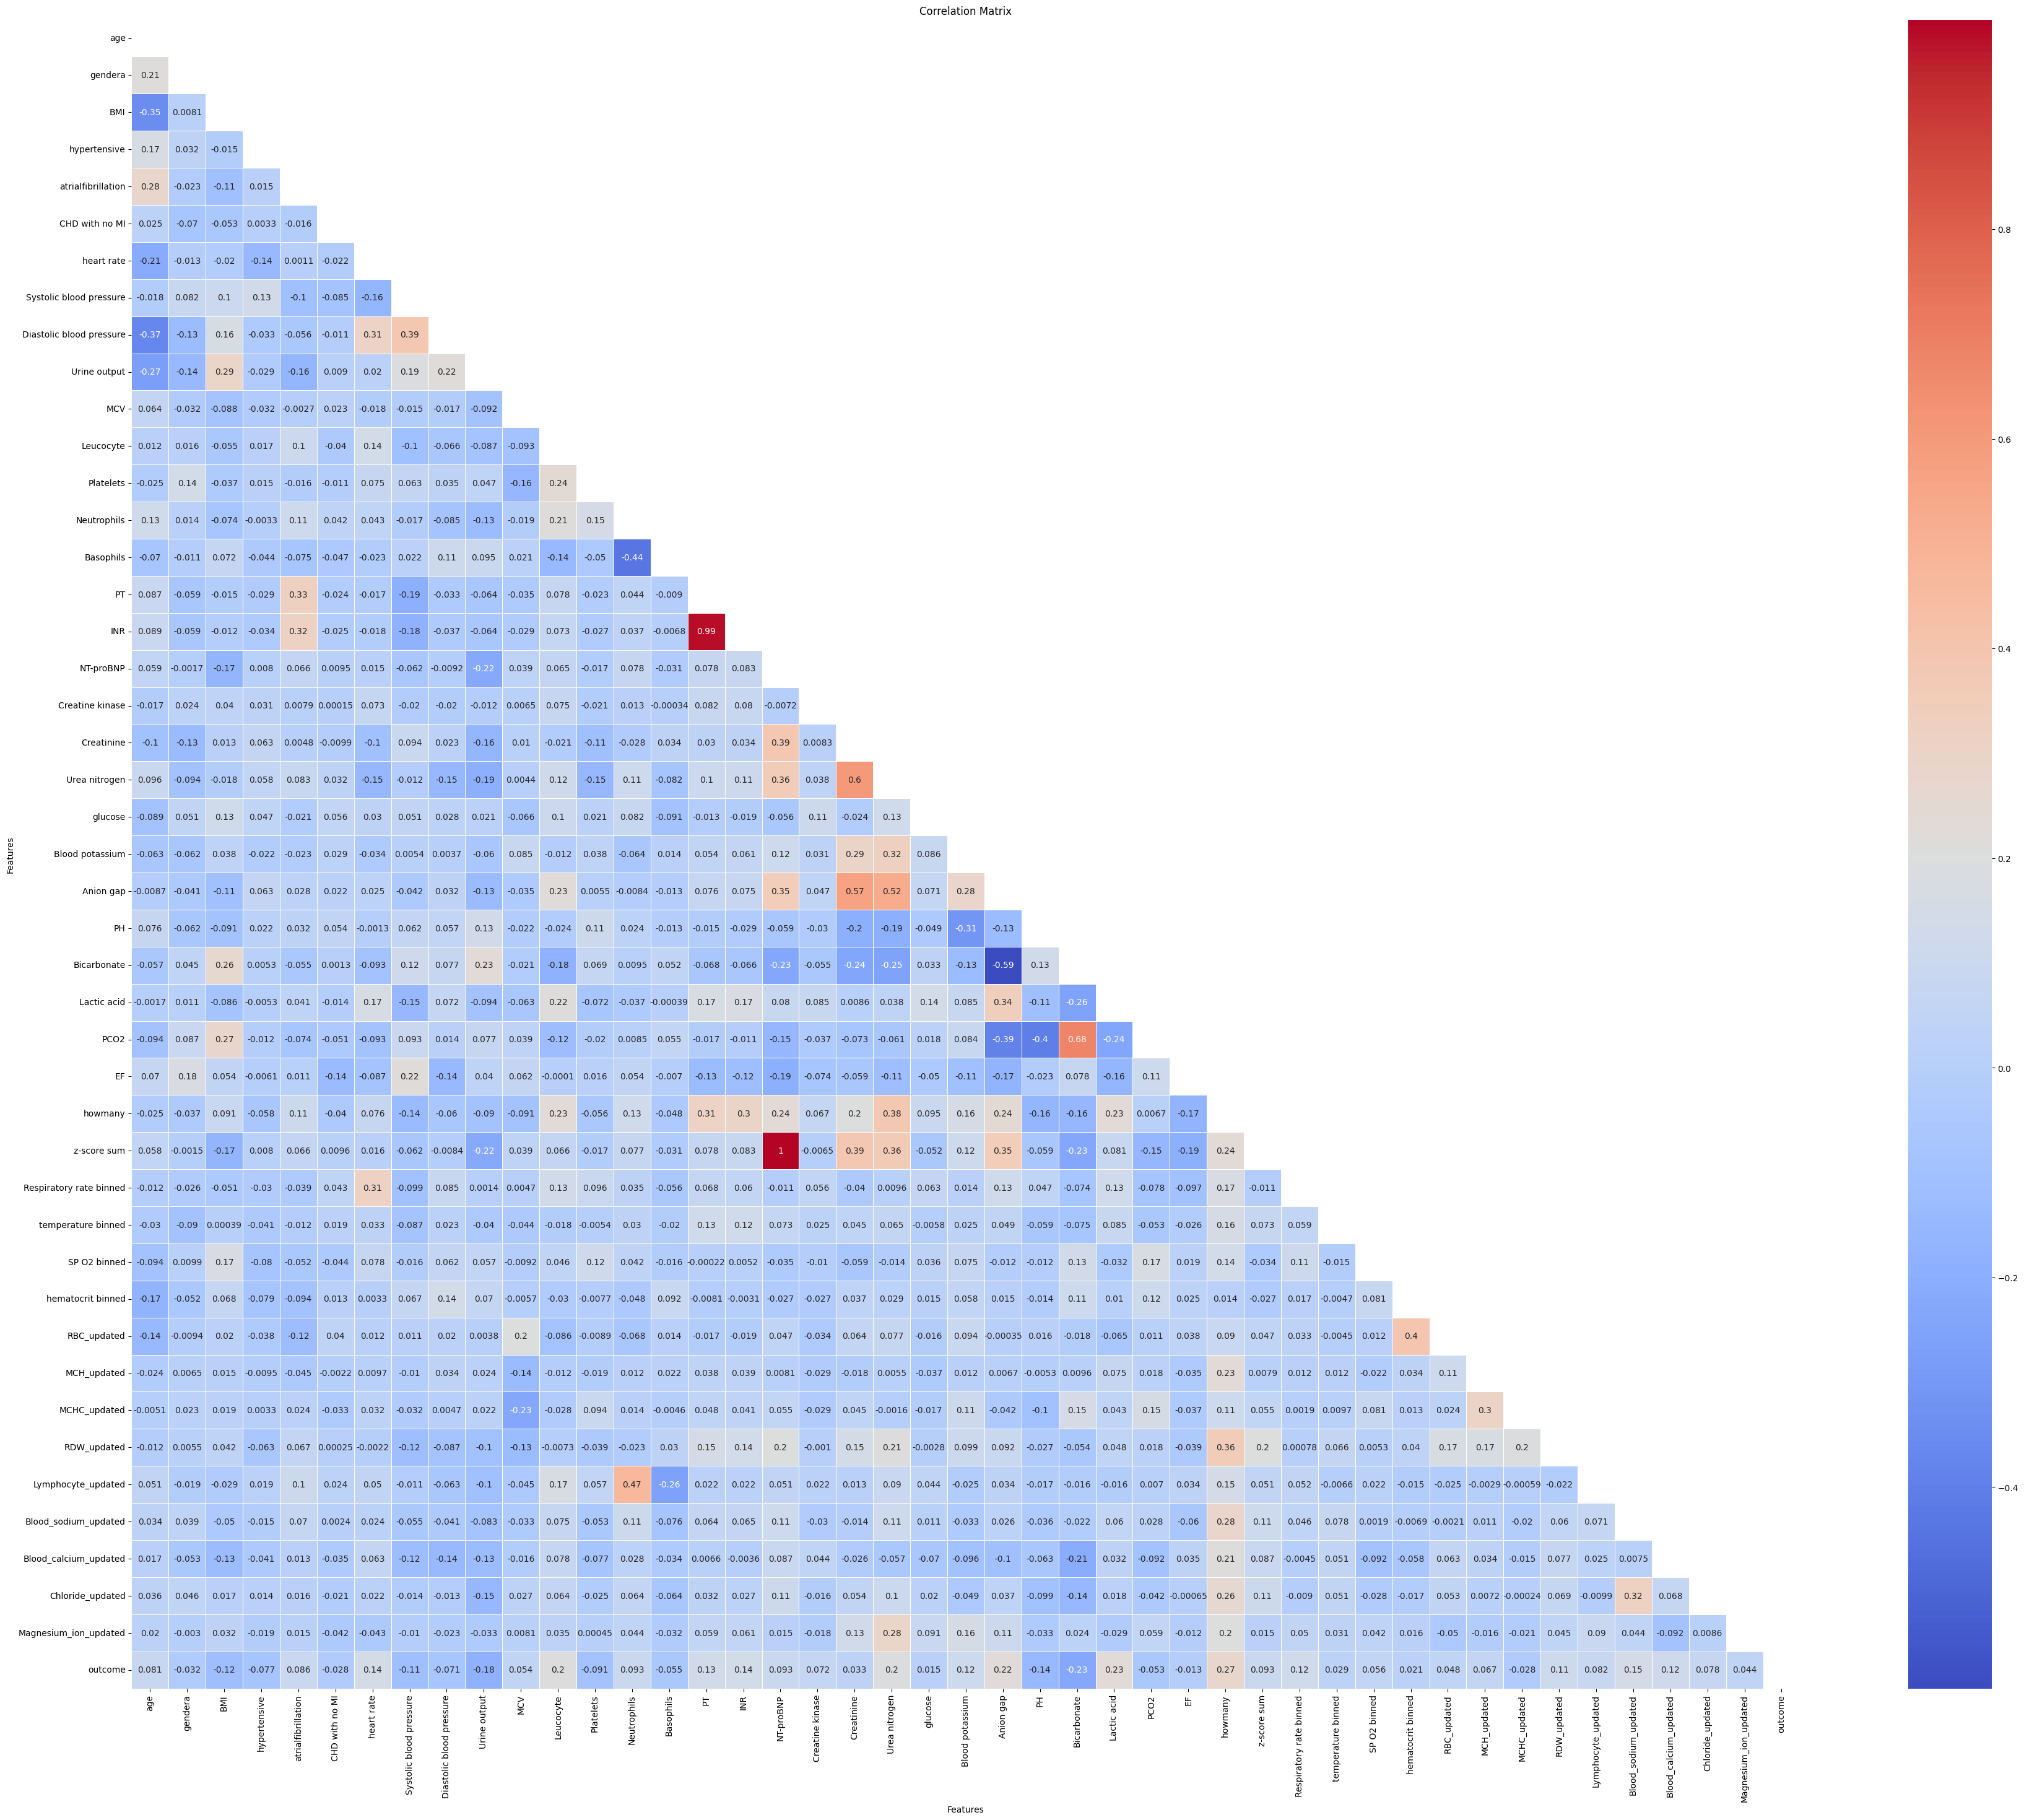

In [21]:
corr_matrix, correlated_pairs = correlation_analysis(df_updated, threshold = 0.9)

In [22]:
def feature_importance_pvalue(df, target_col, threshold=0.5):
    """
    Author: Novin
    Perform linear regression and calculate p-values for each feature in a dataframe.

    Parameters:
        -- df: pd.DataFrame
            The dataframe containing the features and target variable.
        -- target_col: str
            The name of the column containing the target variable.

    Returns:
        -- p_values: pd.Series
            A series containing the p-values for each feature.
    """
    # Separate the features and target variable
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Add constant to the features
    X = sm.add_constant(X)

    # Perform linear regression
    model = sm.OLS(y, X).fit()

    # Get the p-values for each feature
    p_values = model.pvalues.drop('const')
    
    # Sort p-values in ascending order
    p_values = p_values.sort_values(ascending=True)

    # Create a list of feature names where p-value is above the threshold
    above_threshold_features = list(p_values[p_values > threshold].index)

    return p_values, above_threshold_features

In [23]:
p_values, above_threshold_features = feature_importance_pvalue(df_updated, 'outcome', threshold=0.7)

## Variance Inflation Factor

In [95]:
def get_vif(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(0, X.shape[1])]
    vif['Feature'] = X.columns
    return vif

def get_vif_dropped(X, cat_features = [], VIF_threshold = 10):
    drop_feature_vif = []
    X_test_updated_cont = X.drop(cat_features)
    while (True):
        vif = get_vif(X_test_updated_cont)
        if (max(vif['VIF']) < VIF_threshold):
            break
        feature_tbr = vif.loc[vif['VIF'] == max(vif['VIF']),"Feature"].values[0]
        drop_feature_vif.append(feature_tbr)
        l = [False if (i == feature_tbr) else True for i in X_test_updated_cont.columns.values]
        X_test_updated_cont = X_test_updated_cont.loc[:, l]
    print(vif)
    return drop_feature_vif

## Validation Functions 

In [25]:
def get_COPD_score(f):
    s = []
    for i in f:
        if i == 1:
            s.append(2)
        elif i == 0:
            s.append(0)
        else:
            print("error")
    return np.array(s)

def get_hr_score(f):
    s = []
    for i in f:
        if i <= 79:
            s.append(0)
        elif i >= 80 and i <= 84:
            s.append(1)
        elif i >= 85 and i <= 89:
            s.append(3)
        elif i >= 90 and i <= 94:
            s.append(4)
        elif i >= 95 and i <= 99:
            s.append(5)
        elif i >= 100 and i <= 104:
            s.append(6)
        else:
            s.append(8)
    return np.array(s) 

def get_age_score(f):
    s = []
    for i in f:
        if i <= 19:
            s.append(0)
        elif i >= 20 and i <= 29:
            s.append(3)
        elif i >= 30 and i <= 39:
            s.append(6)
        elif i >= 40 and i <= 49:
            s.append(8)
        elif i >= 50 and i <= 59:
            s.append(11)
        elif i >= 60 and i <= 69:
            s.append(14)
        elif i >= 70 and i <= 79:
            s.append(17)
        elif i >= 80 and i <= 89:
            s.append(19)
        elif i >= 90 and i <= 99:
            s.append(22)
        elif i >= 100 and i <= 109:
            s.append(25)
        else:
            s.append(28)
    return np.array(s)

def get_sodium_score(f):
    s = []
    for i in f:
        if i <= 130:
            s.append(4)
        elif i >= 131 and i <= 133:
            s.append(3)
        elif i >= 134 and i <= 136:
            s.append(2)
        elif i >= 137 and i <= 138:
            s.append(1)
        else:
            s.append(0)
    return np.array(s)

def get_BUN_score(f):
    s = []
    for i in f:
        if i <= 9:
            s.append(0)
        elif i >= 10 and i <= 19:
            s.append(2)
        elif i >= 20 and i <= 29:
            s.append(4)
        elif i >= 30 and i <= 39:
            s.append(6)
        elif i >= 40 and i <= 49:
            s.append(8)
        elif i >= 50 and i <= 59:
            s.append(9)
        elif i >= 60 and i <= 69:
            s.append(11)
        elif i >= 70 and i <= 79:
            s.append(13)
        elif i >= 80 and i <= 89:
            s.append(15)
        elif i >= 90 and i <= 99:
            s.append(17)
        elif i >= 100 and i <= 109:
            s.append(19)
        elif i >= 110 and i <= 119:
            s.append(21)
        elif i >= 120 and i <= 129:
            s.append(23)
        elif i >= 130 and i <= 139:
            s.append(25)
        elif i >= 140 and i <= 149:
            s.append(27)
        else:
            s.append(28)
    return np.array(s)

def get_systolic_score(f):
    s = []
    for i in f:
        if i <= 59:
            s.append(28)
        elif i >= 60 and i <= 69:
            s.append(26)
        elif i >= 70 and i <= 79:
            s.append(24)
        elif i >= 80 and i <= 89:
            s.append(23)
        elif i >= 90 and i <= 99:
            s.append(21)
        elif i >= 100 and i <= 109:
            s.append(19)
        elif i >= 110 and i <= 119:
            s.append(17)
        elif i >= 120 and i <= 129:
            s.append(15)
        elif i >= 130 and i <= 139:
            s.append(13)
        elif i >= 140 and i <= 149:
            s.append(11)
        elif i >= 150 and i <= 159:
            s.append(9)
        elif i >= 160 and i <= 169:
            s.append(8)
        elif i >= 170 and i <= 179:
            s.append(6)
        elif i >= 180 and i <= 189:
            s.append(4)
        elif i >= 190 and i <= 199:
            s.append(3)
        else:
            s.append(0)
    return np.array(s)

def get_GWTG_HF_score(X):
    sum = np.zeros(X.shape[0])
    # Systolic BP
    sum += get_systolic_score(X["Systolic blood pressure"].to_numpy())
    # BUN
    sum += get_BUN_score(X["Urea nitrogen"].to_numpy())
    # Sodium
    sum += get_sodium_score(X["Blood sodium"].to_numpy())
    # Age
    sum += get_age_score(X["age"].to_numpy())
    # Heart Rate
    sum += get_hr_score(X["heart rate"].to_numpy())
    # Ethnicity (Missing)
    
    # COPD
    sum += get_COPD_score(X["COPD"].to_numpy())
    return sum

In [26]:
# Model metrics
def test_metrics(name, X, y_t, y_p, y_s = []):
    
    # Confusion Matrix
    cm = confusion_matrix(y_t, y_p, labels = [0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["-", "+"])
    disp.plot()
    plt.show()
    # F1-score
    print(f"f1-score = {f1_score(y_t, y_p):.2f}")
    
    
    if (len(y_s) != 0):
        # get GWTG-HF risk score
        plt.figure()
        gwtg_s = get_GWTG_HF_score(X)
        # ROC curve
        # NOTE ROC curve is not a good metric for inbalance class
        # AUC-ROC curve for our model
        fpr, tpr, thresholds = roc_curve(y_t, y_s, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color = "red", label = f"Model = {name}, AUC = {roc_auc:.2f}")
        # AUC-ROC curve for GWTG_HF
        
        fpr, tpr, thresholds = roc_curve(y_t, gwtg_s, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color = "blue", label = f"Model = GWTG-HF, AUC = {roc_auc:.2f}")
        plt.legend()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()
        
        plt.figure()
        # PR curve
        # AUC-PR curve for our model
        precision, recall, _ = precision_recall_curve(y_t, y_s)
        ap = average_precision_score(y_t, y_s)
        plt.plot(recall, precision, color = "red", label = f"Model = {name}, AP = {ap:.2f}")
        
        # AUC-PR curve for GWTF_HF
        precision, recall, _ = precision_recall_curve(y_t, gwtg_s)
        ap = average_precision_score(y_t, gwtg_s)
        plt.plot(recall, precision, color = "blue", label = f"Model = GWTG-HF, AP = {ap:.2f}")
        plt.legend()
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("PR curve")
        plt.show()
    

## Model Build

### XGboost Model

In [159]:
# Seperate the features and the output 
# Drop the features that are highly correlated and has a p-value below 0.7 
y_sampled_data = df_updated[['outcome']]
X_sampled_data = df_updated.drop(['outcome','gendera', 'NT-proBNP', 'INR','Chloride_updated', 'Diastolic blood pressure',\
                                  'hematocrit binned','SP O2 binned','Magnesium_ion_updated','atrialfibrillation'], axis=1)
X_test_updated = X_test.drop(['gendera', 'NT-proBNP', 'INR','Chloride_updated','Diastolic blood pressure', \
                              'hematocrit binned','SP O2 binned','Magnesium_ion_updated','atrialfibrillation'], axis=1)

In [160]:
# Drop numerical feature based on VIF 

VIF_threshold = 15

print(X_test_updated.columns)
# Copy new feature dataframe and remove categorical features
X_test_updated_cont = X_test_updated.drop(["hypertensive", "CHD with no MI", 'Respiratory rate binned', 'temperature binned', 'RBC_updated', 'MCH_updated', 'MCHC_updated','RDW_updated', 'Lymphocyte_updated', 'Blood_sodium_updated', 'Blood_calcium_updated'], axis = 1)
# Get feature that should be dropped based on VIF
drop_feature_vif = get_vif_dropped(VIF_threshold, X_test_updated, )

print(drop_feature_vif)
X_test_updated = X_test_updated.drop(drop_feature_vif, axis = 1)
X_sampled_data = X_sampled_data.drop(drop_feature_vif, axis = 1)


Index(['age', 'BMI', 'hypertensive', 'CHD with no MI', 'heart rate',
       'Systolic blood pressure', 'Urine output', 'MCV', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'PT', 'Creatine kinase',
       'Creatinine', 'Urea nitrogen', 'glucose', 'Blood potassium',
       'Anion gap', 'PH', 'Bicarbonate', 'Lactic acid', 'PCO2', 'EF',
       'howmany', 'z-score sum', 'Respiratory rate binned',
       'temperature binned', 'RBC_updated', 'MCH_updated', 'MCHC_updated',
       'RDW_updated', 'Lymphocyte_updated', 'Blood_sodium_updated',
       'Blood_calcium_updated'],
      dtype='object')
          VIF                  Feature
0    9.712067                      age
1    5.250328                      BMI
2   10.961504               heart rate
3   11.313665  Systolic blood pressure
4    4.920202             Urine output
5    8.208593                Leucocyte
6    8.269394                Platelets
7    1.301602                Basophils
8    2.538353                       PT
9 

In [161]:
def xgboost_classification(X_dev, y_dev, X_test, y_test):
    """
    Author: Novin
    Train a binary classification model using XGBoost. The hyper-parameters for the model was tuned seperately. 
    The best performing hyper parameters are added here.

    Parameters
    ----------
    X_dev: Training feature dataframe
    y_dev: Training output
    X_test: Testing feature dataframe
    y_test: Testing output

    Returns
    -------
    model : XGBClassifier model.
    accuracy : Accuracy on the test dataset
    """

    # Initialize XGBoost classifier
    model = XGBClassifier(alpha=0.7, max_depth=2, learning_rate=0.9, n_estimators=25, gamma=0.1)

    # Train the model
    model.fit(X_dev, y_dev)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # create X_test that still have those features
    X_test_n = df.loc[X_test.index]
    test_metrics("XGBoost", X_test_n, y_test, y_pred, model.predict_proba(X_test)[:,1])

    return model, accuracy

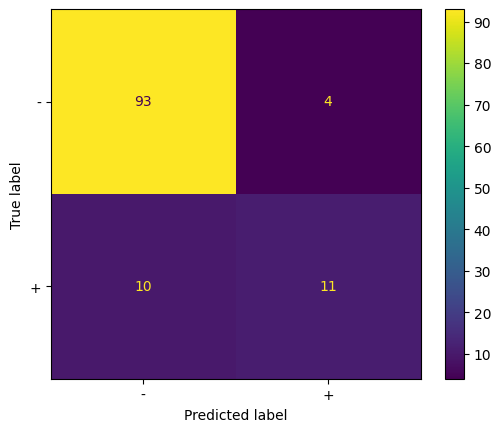

f1-score = 0.61


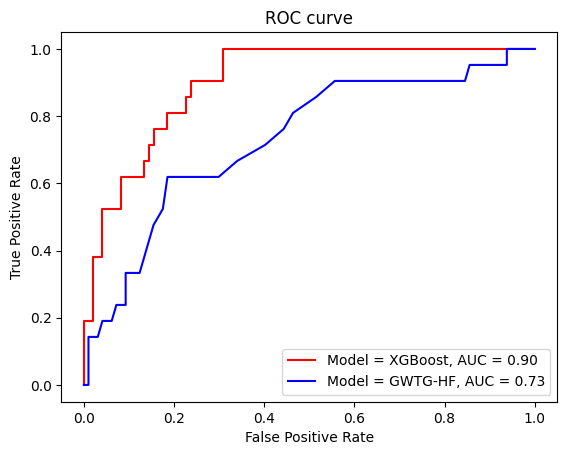

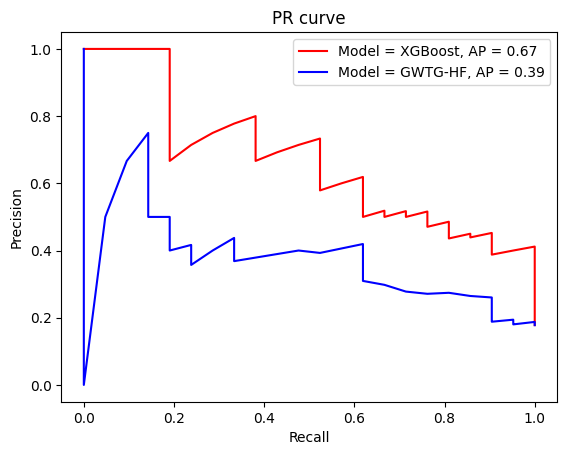

0.8813559322033898

In [162]:
mod, acc = xgboost_classification(X_sampled_data, y_sampled_data, X_test_updated, y_test)
acc


### GBM 

In [163]:
def gbm_classification(X_dev, y_dev, X_test, y_test):
    """
    Author: Novin
    Train a binary classification model using gbm. The hyper-parameters for the model was tuned seperately. 
    The best performing hyper parameters are added here.

    Parameters
    ----------
    X_dev: Training feature dataframe
    y_dev: Training output
    X_test: Testing feature dataframe
    y_test: Testing output

    Returns
    -------
    model : XGBClassifier model.
    accuracy : Accuracy on the test dataset
    """
    
    # Initialize GBM classifier
    model = GradientBoostingClassifier(loss='log_loss', n_estimators=100, learning_rate=0.9,max_depth=1, random_state=42)

    # Train the model
    model.fit(X_dev, y_dev)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # create X_test that still have those features
    X_test_n = df.loc[X_test.index]
    test_metrics("GBM", X_test_n, y_test, y_pred, model.predict_proba(X_test)[:,1])

    return model, accuracy

C:\Users\Bertram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


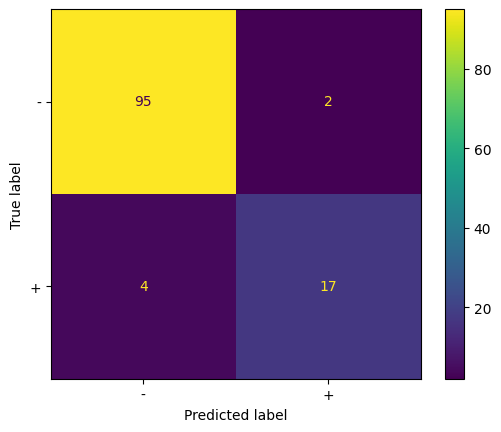

f1-score = 0.85


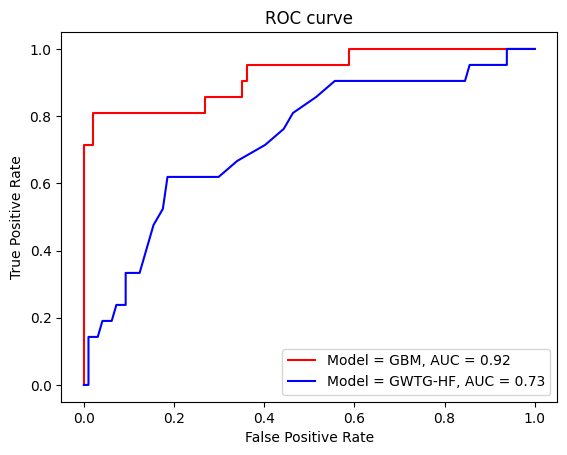

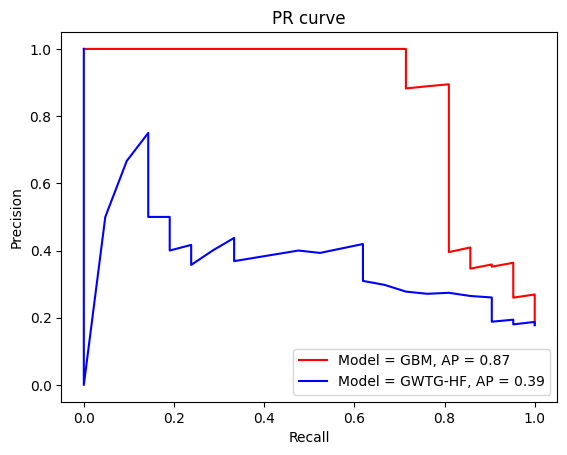

0.9491525423728814

In [164]:
model, accuracy = gbm_classification(X_sampled_data, y_sampled_data, X_test_updated, y_test)
accuracy

### Neural Network

In [165]:
def neural_network_classification(X_train, X_test, y_train, y_test):
    """
    Author: Novin
    Train a binary classification model using gbm. The hyper-parameters for the model was tuned seperately. 
    The best performing hyper parameters are added here.

    Parameters
    ----------
    X_dev: Training feature dataframe
    y_dev: Training output
    X_test: Testing feature dataframe
    y_test: Testing output

    Returns
    -------
    model: XGBClassifier model.
    train_acc: Training set accuracy
    test_acc: Test set accuracy
    """

    # Create the neural network classifier
    model = MLPClassifier(hidden_layer_sizes=(32,16,16,8,), learning_rate='adaptive', batch_size = 250,\
                      momentum=0.9, alpha=0.009, epsilon=1e-12, max_iter=100, beta_1 = 0.9, \
                          random_state=42)

    # Train the neural network model
    model.fit(X_train, y_train)

    # Make predictions on the training and test sets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    # create X_test that still have those features
    # Produce validation graphs
    X_test_n = df.loc[X_test.index]
    test_metrics("Neural_network", X_test_n, y_test, test_preds, model.predict_proba(X_test)[:,1])

    # Return trained model and accuracy scores
    return model, train_acc, test_acc

C:\Users\Bertram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bertram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


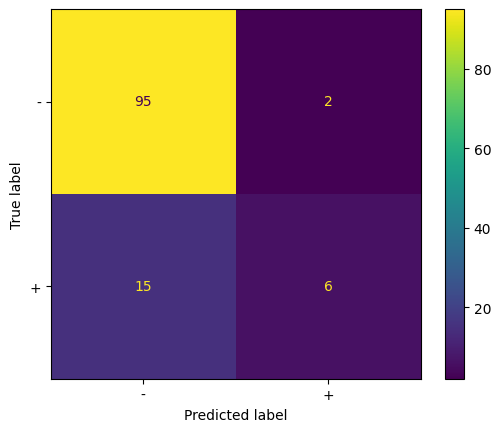

f1-score = 0.41


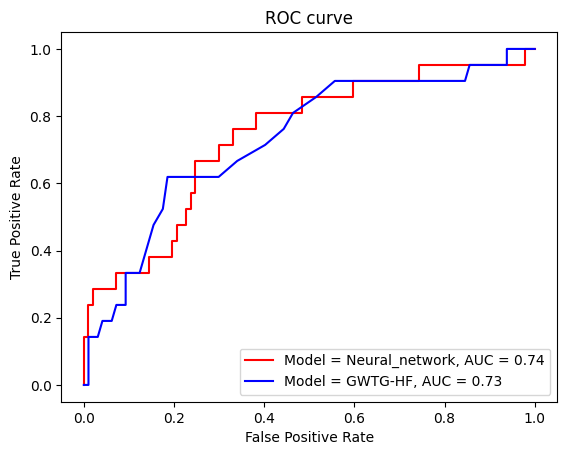

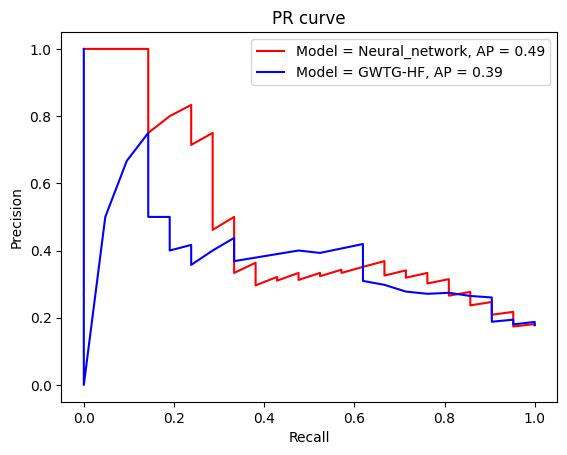

Train Accuracy: 0.9013824884792627
Test Accuracy: 0.8559322033898306


In [166]:
model, train_acc, test_acc = neural_network_classification(X_sampled_data, X_test_updated, y_sampled_data, y_test)
print("Train Accuracy: " + str(train_acc))
print("Test Accuracy: " + str(test_acc))